### Import pakietów

In [407]:
import pandas as pd
pd.options.display.max_columns = None

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### Wczytanie wykorzystywanych tabel z plików CSV

In [408]:
#reading CSV tables
admissions = pd.read_csv("./data/ADMISSIONS.csv")
patients = pd.read_csv("./data/PATIENTS.csv")
services = pd.read_csv("./data/SERVICES.csv")
icustays = pd.read_csv("./data/ICUSTAYS.csv")
drgcodes = pd.read_csv("./data/DRGCODES.csv")
prescriptions = pd.read_csv("./data/PRESCRIPTIONS.csv")
microbiologyevents = pd.read_csv("./data/MICROBIOLOGYEVENTS.csv")

### Imputacja braków

In [409]:
admissions.isnull().sum()

row_id                   0
subject_id               0
hadm_id                  0
admittime                0
dischtime                0
deathtime               89
admission_type           0
admission_location       0
discharge_location       0
insurance                0
language                48
religion                 1
marital_status          16
ethnicity                0
edregtime               37
edouttime               37
diagnosis                0
hospital_expire_flag     0
has_chartevents_data     0
dtype: int64

In [410]:
# Dokonamy imputacji zmiennych kategorycznych
admissions['language'] = admissions['language'].fillna('Missing_language')
admissions['religion'] = admissions['religion'].fillna('Missing_religion') 
admissions['marital_status'] = admissions['marital_status'].fillna('Missing_marital_status')
microbiologyevents['interpretation'] = microbiologyevents['interpretation'].fillna("BRAK")
services['prev_service'] = services['prev_service'].fillna("BRAK")

Braki zmiennych ciągłych uzupełniamy medianą

In [411]:
# Dokonamy imputacji zmiennych ciągłych
drgcodes.drg_severity.fillna(drgcodes.drg_severity.median(), inplace=True)
drgcodes.drg_mortality.fillna(drgcodes.drg_mortality.median(), inplace=True)

### Wybieramy interesujące nas kolumny

In [412]:
admissions_opt = admissions[['subject_id', 'hadm_id', 'admission_type',
                             "insurance", "language", "religion",
                             "marital_status", "ethnicity", "hospital_expire_flag",
                             'admittime', 'dischtime']]
patients_opt = patients[['subject_id', "gender", "dob"]]
services_opt = services[['row_id', 'subject_id', 'hadm_id', 'curr_service']]
icustays_opt = icustays[['subject_id', 'hadm_id', 'los']]
drgcodes_opt = drgcodes.drop(['description', 'row_id', 'drg_code', 'drg_type'], axis = 1)
prescriptions_opt = prescriptions[['subject_id', 'hadm_id', 'drug_type']]
microbiologyevents_opt = microbiologyevents[['subject_id', 'hadm_id', 'interpretation']]

### Kodujemy i grupujemy zmienne będące w wybranych przez nas tabelach

In [413]:
from sklearn.preprocessing import OneHotEncoder

def encode_and_join(encode, df):
    enc = OneHotEncoder(handle_unknown='ignore')
    
    enc_df = pd.DataFrame(
        enc.fit_transform(df[encode]).toarray(),
        columns = enc.get_feature_names(input_features = encode)
    )
    
    return df.join(enc_df).drop(encode, axis = 1)

- admissions

In [414]:
encode = ["admission_type", "insurance", "language", "religion", "marital_status", "ethnicity"]
admissions_opt = encode_and_join(encode , admissions_opt)

- patients

In [415]:
encode = ['gender']
patients_opt['gender'] = patients_opt['gender'].astype('category').cat.codes

- services

In [416]:
encode = ['curr_service']
services_opt = encode_and_join(encode, services_opt)

services_opt = services_opt.groupby(by = ['subject_id','hadm_id']).sum().reset_index().drop('row_id', axis = 1)
services_opt.shape

(129, 14)

- icustays

In [417]:
icustays_opt = icustays_opt.groupby(by = ['subject_id', 'hadm_id']).sum().reset_index()
icustays_opt.shape

(129, 3)

- drgcodes

In [418]:
drgcodes_opt = drgcodes_opt.groupby(
    by = ['subject_id', 'hadm_id'])[['drg_severity', 'drg_mortality']].mean().join(
    drgcodes_opt.groupby(by = ['subject_id', 'hadm_id']).sum().drop(['drg_severity', 'drg_mortality'], axis = 1)
).reset_index()
drgcodes_opt.shape

(129, 4)

- prescriptions

In [419]:
encode = ['drug_type']
prescriptions_opt = encode_and_join(encode, prescriptions_opt)

prescriptions_opt = prescriptions_opt.groupby(by = ['subject_id', 'hadm_id']).sum().reset_index()
prescriptions_opt.shape # nie kazdy pacjent otrzymal recepte

(122, 5)

In [420]:
encode = ['interpretation']

microbiologyevents_opt = encode_and_join(encode, microbiologyevents_opt)
microbiologyevents_opt = microbiologyevents_opt.groupby(by = ['subject_id', 'hadm_id']).sum().reset_index()
microbiologyevents_opt.shape # nie każde przyjęcie testowało tą zmienną, trzeba będzie później nadpisać NA

(120, 6)

### Łączymy wszystkie tabele

In [421]:
df2 = admissions_opt.join(patients_opt.set_index("subject_id"), on = "subject_id")
df2 = df2.join(services_opt.set_index(["subject_id", "hadm_id"]), on = ["subject_id", "hadm_id"])
df2 = df2.join(icustays_opt.set_index(["subject_id", "hadm_id"]), on = ["subject_id", "hadm_id"])
df2 = df2.join(drgcodes_opt.set_index(["subject_id", "hadm_id"]), on = ["subject_id", "hadm_id"])
df2 = df2.join(prescriptions_opt.set_index(["subject_id", "hadm_id"]), on = ["subject_id", "hadm_id"])
df2 = df2.join(microbiologyevents_opt.set_index(["subject_id", "hadm_id"]), on = ["subject_id", "hadm_id"])

In [422]:
# przypisujemy każdej wzycie 0 przypisanych recept skoro nie zostaly one zanotowane
df2.drug_type_ADDITIVE.fillna(0, inplace=True)
df2.drug_type_BASE.fillna(0, inplace=True)
df2.drug_type_MAIN.fillna(0, inplace=True)
# to samo z interpretation
df2.interpretation_BRAK.fillna(1, inplace=True)
df2.interpretation_I.fillna(0, inplace=True)
df2.interpretation_R.fillna(0, inplace=True)
df2.interpretation_S.fillna(0, inplace=True)

In [423]:
# dodajemy zmienną "age" zamiast dob i admittime

In [424]:
from datetime import datetime
#age
df2['admittime'] =  pd.to_datetime(df2['admittime'], format='%Y-%m-%d')
df2["dischtime"] = pd.to_datetime(df2['dischtime'], format='%Y-%m-%d')
df2['dob'] =  pd.to_datetime(df2['dob'], format='%Y-%m-%d')
length = df2["admittime"].apply(lambda x: x.year) - df2["dob"].apply(lambda x: x.year)
df2['age'] = length
#Patients who are older than 89 years old - 300 years
df2.age = df2.age.replace(300, 90)
#length of total admission
length = df2["dischtime"] - df2["admittime"]
df2['adm_length'] = length.dt.days
df2 = df2.drop(['admittime', 'dob', 'dischtime'], axis=1)

### Balans klas zmiennej celu

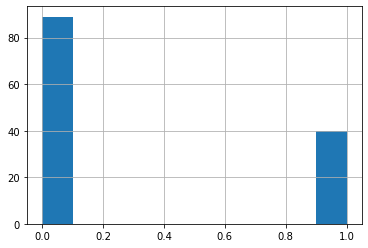

In [425]:
df2.hospital_expire_flag.hist()
plt.show()

In [426]:
#Możemy usunąć kolumny ID
df2 = df2.drop(['subject_id', 'hadm_id'],axis=1)

In [427]:
df2.describe()

,hospital_expire_flag,admission_type_ELECTIVE,admission_type_EMERGENCY,admission_type_URGENT,insurance_Government,insurance_Medicaid,insurance_Medicare,insurance_Private,language_ENGL,language_MAND,language_Missing_language,language_POLI,language_RUSS,language_SPAN,religion_BUDDHIST,religion_CATHOLIC,religion_CHRISTIAN SCIENTIST,religion_JEWISH,religion_MUSLIM,religion_Missing_religion,religion_NOT SPECIFIED,religion_OTHER,religion_PROTESTANT QUAKER,religion_ROMANIAN EAST. ORTH,religion_UNOBTAINABLE,marital_status_DIVORCED,marital_status_MARRIED,marital_status_Missing_marital_status,marital_status_SEPARATED,marital_status_SINGLE,marital_status_UNKNOWN (DEFAULT),marital_status_WIDOWED,ethnicity_AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE,ethnicity_ASIAN,ethnicity_BLACK/AFRICAN AMERICAN,ethnicity_HISPANIC OR LATINO,ethnicity_HISPANIC/LATINO - PUERTO RICAN,ethnicity_OTHER,ethnicity_UNABLE TO OBTAIN,ethnicity_UNKNOWN/NOT SPECIFIED,ethnicity_WHITE,gender,curr_service_CMED,curr_service_CSURG,curr_service_GU,curr_service_MED,curr_service_NMED,curr_service_NSURG,curr_service_OMED,curr_service_ORTHO,curr_service_SURG,curr_service_TRAUM,curr_service_TSURG,curr_service_VSURG,los,drg_severity,drg_mortality,drug_type_ADDITIVE,drug_type_BASE,drug_type_MAIN,interpretation_BRAK,interpretation_I,interpretation_R,interpretation_S,age,adm_length
count,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000
mean,0.310078,0.062016,0.922481,0.015504,0.007752,0.046512,0.759690,0.186047,0.449612,0.007752,0.372093,0.007752,0.038760,0.124031,0.007752,0.457364,0.023256,0.077519,0.015504,0.007752,0.147287,0.031008,0.077519,0.007752,0.147287,0.046512,0.465116,0.124031,0.007752,0.201550,0.038760,0.116279,0.015504,0.015504,0.054264,0.015504,0.116279,0.023256,0.007752,0.085271,0.666667,0.542636,0.108527,0.046512,0.007752,0.674419,0.046512,0.038760,0.124031,0.007752,0.116279,0.031008,0.046512,0.015504,4.694063,3.739018,3.135659,0.558140,20.286822,59.759690,8.069767,0.410853,2.062016,5.054264,70.271318,8.775194
std,0.464328,0.242124,0.268456,0.124027,0.088045,0.211411,0.428938,0.390661,0.499394,0.088045,0.485247,0.088045,0.193774,0.330902,0.088045,0.500121,0.151302,0.268456,0.124027,0.088045,0.355773,0.174014,0.268456,0.088045,0.355773,0.211411,0.500726,0.330902,0.088045,0.402722,0.193774,0.321809,0.124027,0.124027,0.227420,0.124027,0.321809,0.151302,0.088045,0.280374,0.473242,0.500121,0.336348,0.245601,0.088045,0.486743,0.211411,0.193774,0.414724,0.088045,0.345233,0.174014,0.211411,0.124027,6.485314,0.395200,0.437881,3.365512,26.539827,62.257752,10.320782,1.129245,4.889005,9.422637,16.372496,12.697342
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.105900,2.666667,1.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000

### Rozkłady niektórych ze zmiennych

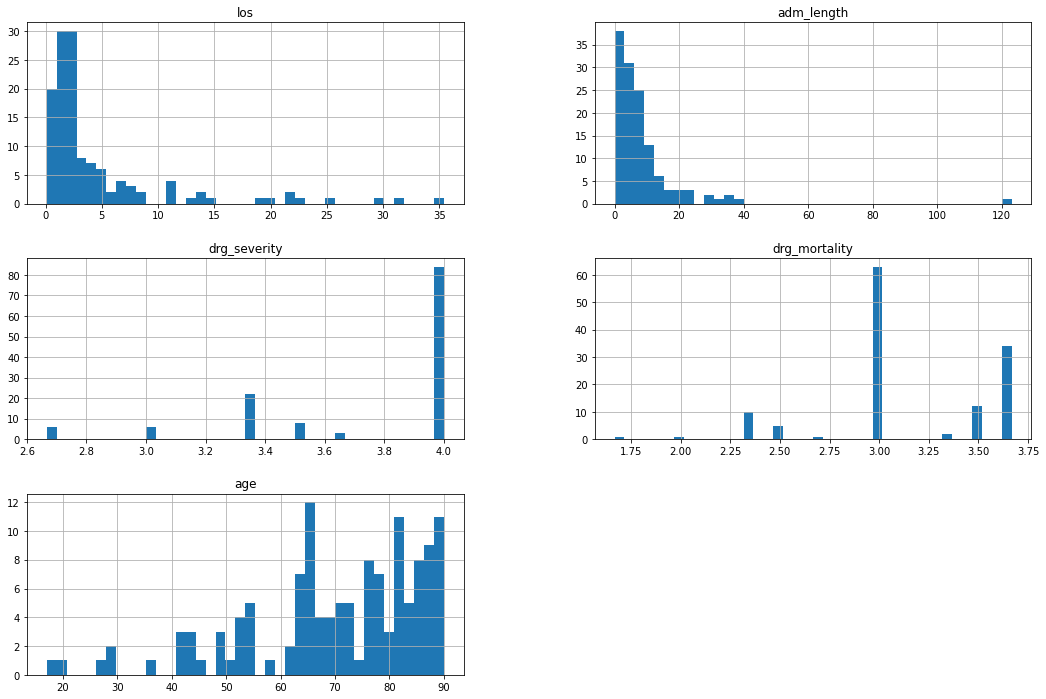

In [428]:
df2[['los', 'adm_length', 'drg_severity', 'drg_mortality', 'age']].hist(bins = 40, figsize=(18, 12))
plt.show()

### Korelacje zmiennych ciągłych

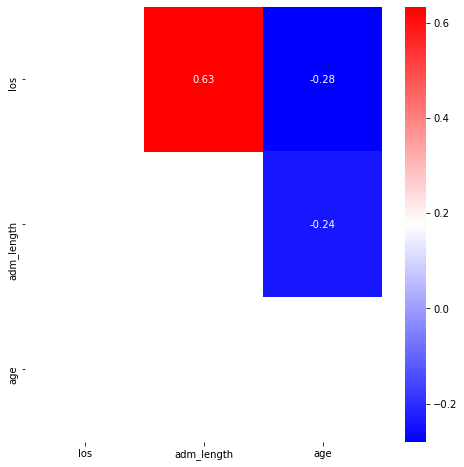

In [429]:
df_corr = df2[['los', 'adm_length', 'age']].corr()
mask = np.triu(np.ones_like(df_corr, dtype=bool)).transpose()

plt.subplots(figsize=(8, 8))
sns.heatmap(df_corr, mask = mask, cmap = 'bwr', annot=True, fmt='.2f')
plt.show()

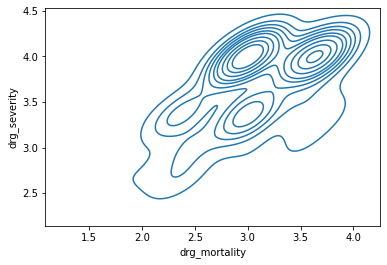

In [430]:
sns.kdeplot(data = df2, y="drg_severity", x="drg_mortality")
plt.show()

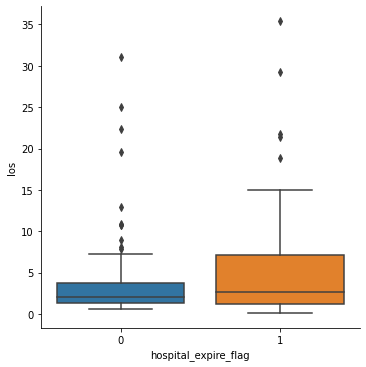

In [431]:
sns.catplot(x="hospital_expire_flag", y="los", data=df2, kind="box")

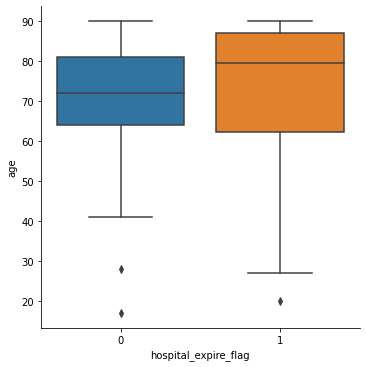

In [432]:
sns.catplot(x="hospital_expire_flag", y="age", data=df2, kind="box")

## Modele

In [433]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [434]:
y = np.array(df2['hospital_expire_flag'])
X = df2.drop(['hospital_expire_flag'],axis=1)

### Train-Test split

In [435]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [436]:
X.head()

,admission_type_ELECTIVE,admission_type_EMERGENCY,admission_type_URGENT,insurance_Government,insurance_Medicaid,insurance_Medicare,insurance_Private,language_ENGL,language_MAND,language_Missing_language,language_POLI,language_RUSS,language_SPAN,religion_BUDDHIST,religion_CATHOLIC,religion_CHRISTIAN SCIENTIST,religion_JEWISH,religion_MUSLIM,religion_Missing_religion,religion_NOT SPECIFIED,religion_OTHER,religion_PROTESTANT QUAKER,religion_ROMANIAN EAST. ORTH,religion_UNOBTAINABLE,marital_status_DIVORCED,marital_status_MARRIED,marital_status_Missing_marital_status,marital_status_SEPARATED,marital_status_SINGLE,marital_status_UNKNOWN (DEFAULT),marital_status_WIDOWED,ethnicity_AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE,ethnicity_ASIAN,ethnicity_BLACK/AFRICAN AMERICAN,ethnicity_HISPANIC OR LATINO,ethnicity_HISPANIC/LATINO - PUERTO RICAN,ethnicity_OTHER,ethnicity_UNABLE TO OBTAIN,ethnicity_UNKNOWN/NOT SPECIFIED,ethnicity_WHITE,gender,curr_service_CMED,curr_service_CSURG,curr_service_GU,curr_service_MED,curr_service_NMED,curr_service_NSURG,curr_service_OMED,curr_service_ORTHO,curr_service_SURG,curr_service_TRAUM,curr_service_TSURG,curr_service_VSURG,los,drg_severity,drg_mortality,drug_type_ADDITIVE,drug_type_BASE,drug_type_MAIN,interpretation_BRAK,interpretation_I,interpretation_R,interpretation_S,age,adm_length
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.6325,4.0,3.0,0.0,9.0,45.0,13.0,1.0,3.0,3.0,70,8
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.8507,4.0,3.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,36,13
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.6499,4.0,3.0,0.0,12.0,24.0,3.0,0.0,0.0,0.0,87,2
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.1436,3.5,3.0,0.0,18.0,87.0,2.0,0.0,0.0,0.0,74,8
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.2938,4.0,3.0,10.0,40.0,49.0,3.0,0.0,1.0,9.0,49,0


## Regresja logistyczna

In [437]:
lr = LogisticRegression(max_iter=1000, random_state=0)

lr.fit(X_train,y_train)
y_hat = lr.predict(X_test)
print('y:     ' + str(y_test[0:20]) + '\ny_hat: ' + str(y_hat[0:20]))

y:     [0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 1 0 0 1 0]
y_hat: [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0]


In [438]:
# accuracy: zbiór testowy

In [439]:
lr.score(X_test, y_test)

0.7435897435897436

### Tuning model liniowy

In [440]:
from scipy.stats import uniform

distributions = dict(C=uniform(loc=0, scale=4),
                     solver = ['liblinear', 'saga'],
                     penalty=['l2', 'l1', 'elasticnet', 'none'])

clf = RandomizedSearchCV(lr, distributions, random_state=0)
search = clf.fit(X_train, y_train)
search.best_score_

0.7888888888888889

In [441]:
# najlepszy model
lm_tunned = search.best_estimator_

# accuracy: zbiór testowy
lm_tunned.score(X_test, y_test)

0.7948717948717948

## Random Forest

In [442]:
rfc = RandomForestClassifier(random_state = 0)

rfc.fit(X_train,y_train)
y_hat = rfc.predict(X_test)
print('y:     ' + str(y_test[0:20]) + '\ny_hat: ' + str(y_hat[0:20]))

y:     [0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 1 0 0 1 0]
y_hat: [0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 0]


In [443]:
rfc.score(X_test, y_test)

0.7692307692307693

### Tuning RF

In [444]:
# grid parametrów
n_estimators = [i for i in range(50,2000, 100)]
max_depth = [i for i in range(2, 52, 2)]
min_sample_leaf = [1, 2, 4, 6, 8]
min_samples_split = [2, 5, 8, 10]

random_grid = dict(n_estimators = n_estimators,
                   max_depth = max_depth,
                   min_samples_leaf = min_sample_leaf,
                   min_samples_split = min_samples_split)

rf = RandomForestClassifier()
rf_cv = RandomizedSearchCV(estimator = rf,
                           param_distributions = random_grid,
                           cv = 3,
                           random_state=42,
                           n_jobs=-1)

# fit cross-validacji
rf_cv.fit(X_train, y_train)
rf_cv.best_score_

0.7444444444444445

In [445]:
# najlepszy model
rf_tunned = rf_cv.best_estimator_

# accuracy: zbiór testowy
rf_tunned.score(X_test, y_test)

0.7948717948717948